## Testing the metadata Extractor

#### BY: Junaid Ramzan Bhat
#### Submitted to: Gilles LANDAIS

# Introduction

This Jupyter Notebook is designed to test and demonstrate the functionality of a Python library developed for working with FITS metadata, spatial coverage, and image search capabilities. The main goals of this notebook are:

1. **Homogenized Metadata Creation**:
   - Extract metadata from a collection of FITS files, standardize the information, and store it in a CSV format for further analysis.
   - Ensure metadata includes key attributes such as RA, DEC, RADESYS, DATE-OBS, INSTRUME, TELESCOP, and others.

2. **Adding MOCs and Polygons**:
   - Generate Multi-Order Coverage (MOC) maps for the spatial coverage of FITS files.
   - Create and add STCS (Simple Table Coordinate Syntax) Polygons to represent image coverage regions.

3. **Point Search**:
   - Test if a specific point (RA, DEC) lies within the spatial coverage of any FITS file in the collection.
   - Use a point-in-polygon algorithm to determine intersections with the image coverage.

4. **Region Search**:
   - Test if a given region (circular or polygonal) intersects with the spatial coverage of any FITS file.
   - Identify and list FITS files whose spatial coverage partially or fully overlaps with the specified region.

5. **Visualization**:
   - Plot the MOC and corresponding FITS image for selected files.
   - Save the generated plots for future reference.

This notebook is structured to provide a detailed overview of the implemented functionalities, along with code examples, results, and explanations. It demonstrates how to utilize the library to perform tasks such as metadata extraction, MOC creation, spatial queries, and visualization.


# Importing Required Functions and Libraries

In below cells, we import all the necessary functions and libraries that will be used throughout the notebook to perform the various tasks. Here’s a breakdown of the imports:

1. **Functions from the Custom Library**:
   - `resolve_object_name`: Resolves the name of a celestial object using the Sesame service.
   - `extract_fits_metadata`: Extracts and homogenizes metadata from FITS files, including RA, DEC, MOC, and Polygon.
   - `create_fits_csv`: Creates a CSV file containing metadata extracted from a collection of FITS files.
   - `is_in_polygon`: Determines whether a given point lies inside a polygon region.

2. **Libraries**:
   - `astropy.io.fits`: For handling FITS file input/output operations.
   - `csv`: For reading and writing CSV files.
   - `mocpy.MOC`: For creating and manipulating Multi-Order Coverage (MOC) maps.
   - `matplotlib.pyplot`: For plotting MOCs and FITS images.
   - `os`: For managing file paths and directories.
   - `astropy.wcs.WCS`: For working with World Coordinate System (WCS) information.
   - `pandas`: For data manipulation, specifically for reading and handling metadata CSVs.


In [1]:
# Importing the functions to test
from functions import (
    resolve_object_name,
    extract_fits_metadata,
    create_fits_csv,
    is_in_polygon,
)

In [2]:
from astropy.io import fits
import csv
from mocpy import MOC
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd


INFO: NumExpr defaulting to 12 threads.


In [3]:
# Folder containing the fits files
fits_folder = "fitscollection"
# store homogenized output
output_file = "metadata_set.csv"
# Replace these accordingly for your folder in the local file 

### Creating the CSV File with Homogenized Metadata

In this step, we generate a CSV file containing homogenized metadata extracted from a collection of FITS files. The command:


In [4]:
table = create_fits_csv(fits_folder,output_file)  # Homogenized metadata


INFO: Resolved 'midz_cell10_25342' to '# midz cell10 25342	#Q10346331'.
INFO: Resolved '2-38011' to '# 2-38011	#Q10346334'.
INFO: Resolved 'r143' to '# r143	#Q10346335'.
INFO: Input object name is empty or 'unknown'. Returning 'Unknown'.
INFO: Input object name is empty or 'unknown'. Returning 'Unknown'.
INFO: Input object name is empty or 'unknown'. Returning 'Unknown'.
INFO: Input object name is empty or 'unknown'. Returning 'Unknown'.
INFO: Input object name is empty or 'unknown'. Returning 'Unknown'.
INFO: Resolved 'G9.62+0.19_NorthMiddle' to '# G9.62+0.19 NorthMiddle	#Q10346337'.
INFO: Input object name is empty or 'unknown'. Returning 'Unknown'.
INFO: Resolved 'CL0412IALL[1/1]' to '# CL0412IALL[1/1]	#Q10346340'.
INFO: Resolved 'CL0303RALL[1/1]' to '# CL0303RALL[1/1]	#Q10346342'.
INFO: Resolved '022 P9870' to '# 022 P9870	#Q10346344'.
INFO: Resolved 'VIRGO-1' to '# VIRGO-1	#Q10346346'.
INFO: Resolved 'sn1987a' to '# sn1987a	#Q10346348'.
INFO: Resolved 'SNR1987A' to '# SNR1987A	#Q1

### Loading and Plotting MOCs with File Saving

This code performs the following tasks:

1. **Load MOCs and Filenames from CSV**:
   - The `load_mocs_and_filenames` function reads MOC strings and filenames from the homogenized metadata CSV file.
   - Each MOC string is parsed into a MOC object (if valid) and paired with its corresponding filename.

2. **Plotting and Saving MOCs**:
   - The `plot_moc_matplotlib` function visualizes the MOC regions using Matplotlib.
   - The plots are optionally saved as PNG files in a specified directory (`save_directory`).

3. **Saving the Results**:
   - A loop iterates over the loaded MOC data, plotting each valid MOC.
   - If a save path is provided, each plot is saved with a filename based on the FITS file's name.

This section automates the visualization and storage of MOCs for easy access and verification.


In [5]:
def load_mocs_and_filenames(csv_path, moc_column="MOC", filename_column="FILENAME"):
    """
    Reads MOC text strings and filenames from a CSV, parses them into MOC objects,
    and returns a list of (moc_obj, filename).

    Parameters
    ----------
    csv_path : str
        Path to the CSV file created by 'create_fits_csv'.
    moc_column : str, optional
        Name of the column containing the MOC strings (default 'MOC').
    filename_column : str, optional
        Name of the column containing the filename (default 'FILENAME').

    Returns
    -------
    list of (MOC or None, str)
        Each entry is a tuple (moc_obj, filename). If the MOC cannot be parsed,
        moc_obj will be None, but filename will still be the CSV's filename column.
    """
    data = []
    with open(csv_path, "r", newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            moc_str = row.get(moc_column, "")
            fname = row.get(filename_column, "Unknown")

            if moc_str and moc_str.strip() != "None":
                try:
                    moc_obj = MOC.from_string(moc_str)
                    data.append((moc_obj, fname))
                except Exception as e:
                    print(f"Could not parse MOC string '{moc_str}': {e}")
                    data.append((None, fname))
            else:
                # No valid MOC in this row
                data.append((None, fname))
    return data


In [6]:
def plot_moc_matplotlib(moc_obj, title="MOC Coverage", save_path=None):
    """
    Plots a single MOC object using Matplotlib and the MOC's built-in WCS.
    Optionally saves the plot to a specified file.

    Parameters
    ----------
    moc_obj : MOC
        A MOC object from the mocpy library.
    title : str
        Title of the plot.
    save_path : str, optional
        File path to save the plot. If None, the plot is only displayed.
    """
    fig = plt.figure(figsize=(8, 6))
    try:
        wcs = moc_obj.wcs(fig=fig)  # Build a WCS for the MOC coverage (mocpy >= 0.10)
    except AttributeError:
        print("Your mocpy is too old for moc_obj.wcs(fig=...). Please upgrade mocpy >= 0.10.")
        return

    ax = fig.add_subplot(111, projection=wcs)

    # Fill the MOC region with semi-transparent blue
    moc_obj.fill(ax=ax, wcs=wcs, alpha=0.4, color="blue")
    # Draw the MOC border in red
    moc_obj.border(ax=ax, wcs=wcs, alpha=1.0, color="red")

    ax.grid(True, ls=":")
    ax.set_title(title)

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
        print(f"Plot saved to: {save_path}")

    plt.show()


Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\2013.1.00034.S_SB_X5_GB_X6_MB_X7_midz_cell10_25342_sci.spw0_1_2_3.cont.I.image_moc.png


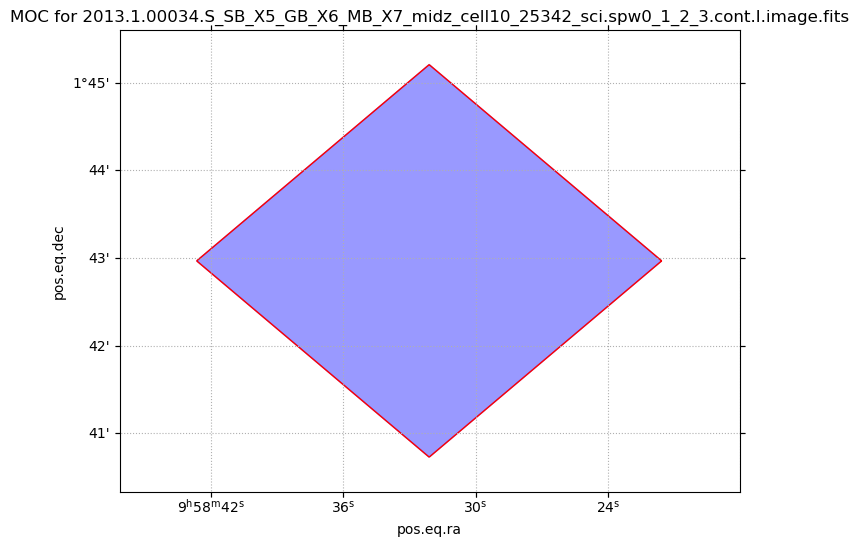

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\2013.1.01292.S_SB_X4eb_GB_X4ec_MB_X4ed_2-38011_sci.spw0_1_2_3.cont.I.image_moc.png


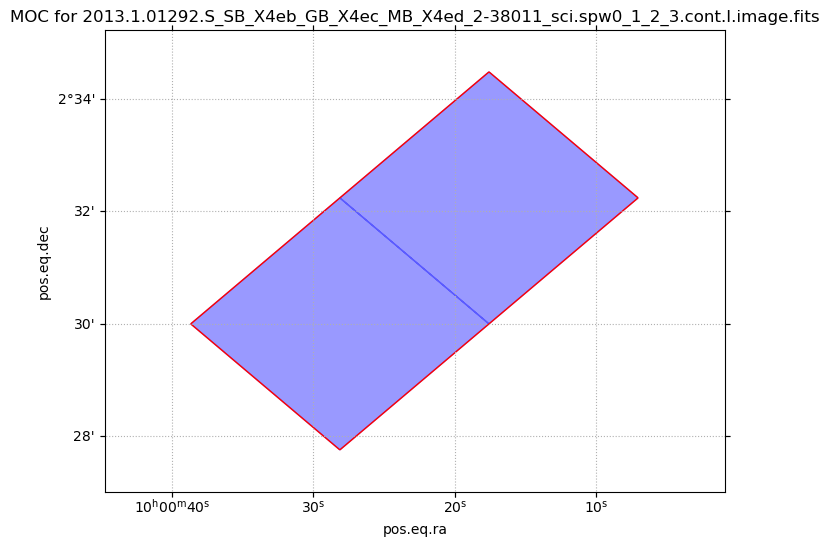

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\5GHz_n_f_moc.png


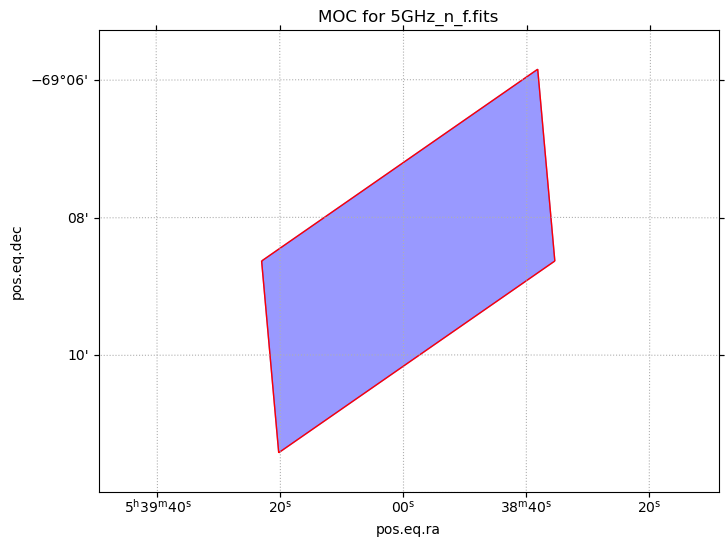

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\av_galcen_2mass_moc.png


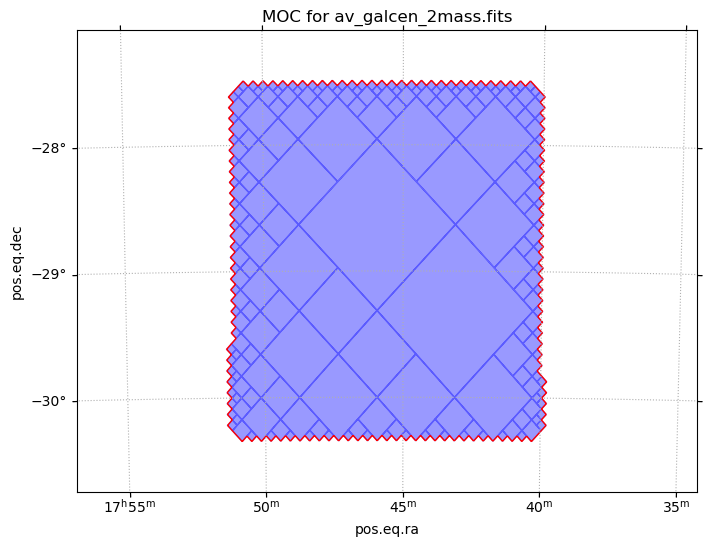

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\av_galcen_spitzer_moc.png


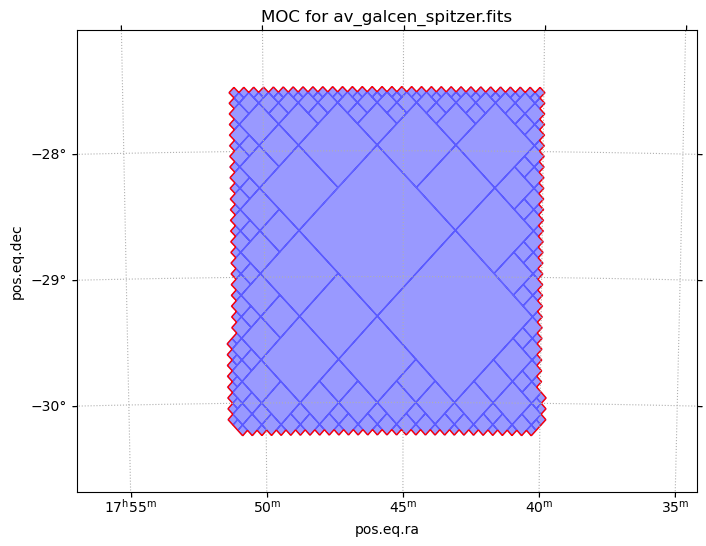

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\G327.617-0.364_I4_moc.png


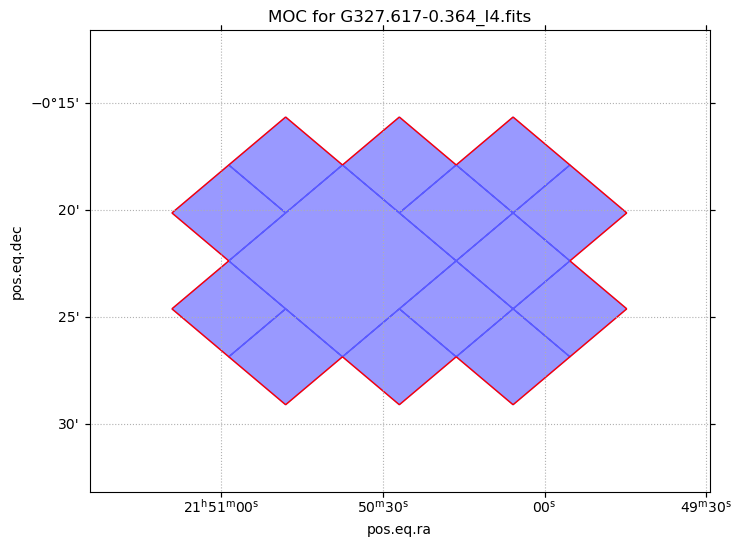

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\G351.632-0.459_atlasgal_moc.png


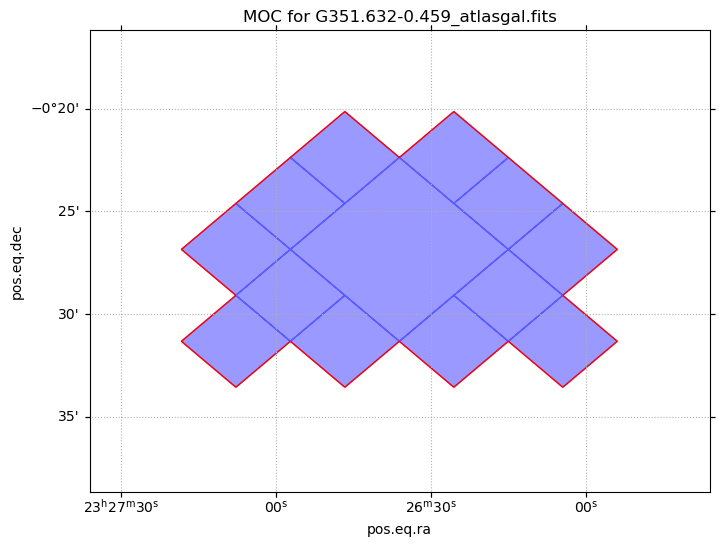

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\G351.702+0.672_atlasgal_moc.png


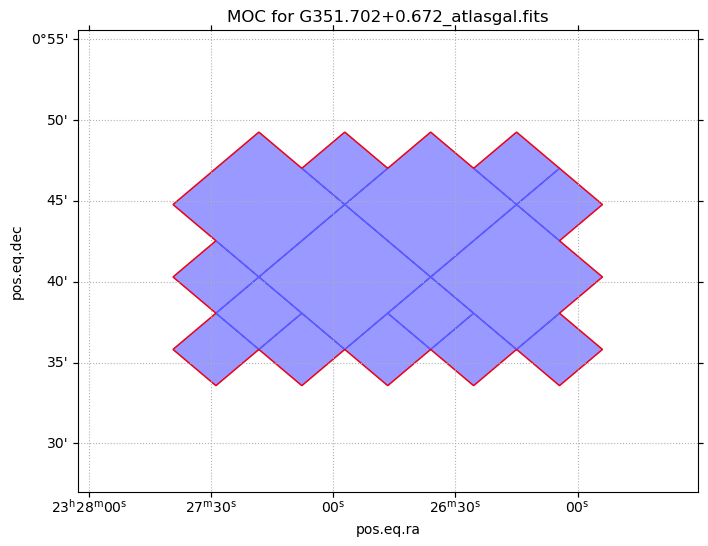

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\G9_POLIN_moc.png


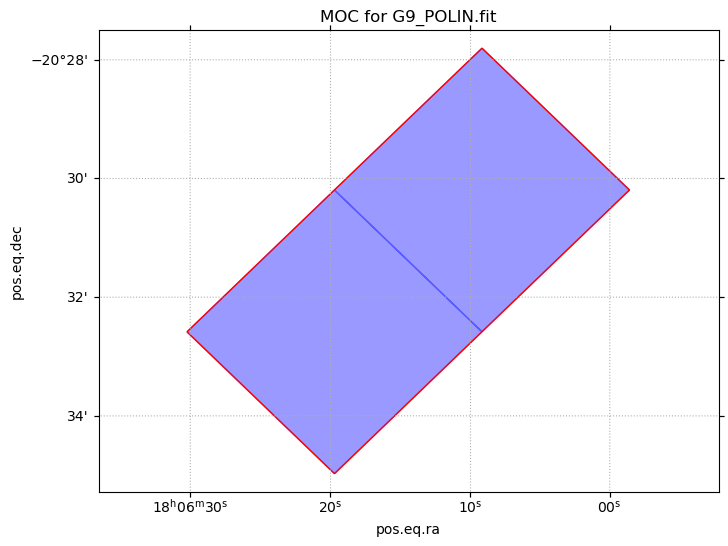

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\id12_GAL-Survey-GC.fpsf_moc.png


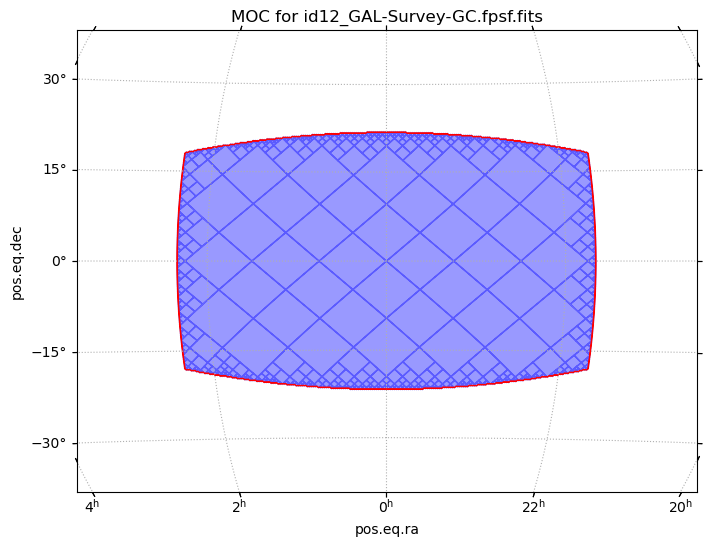

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\imageih_moc.png


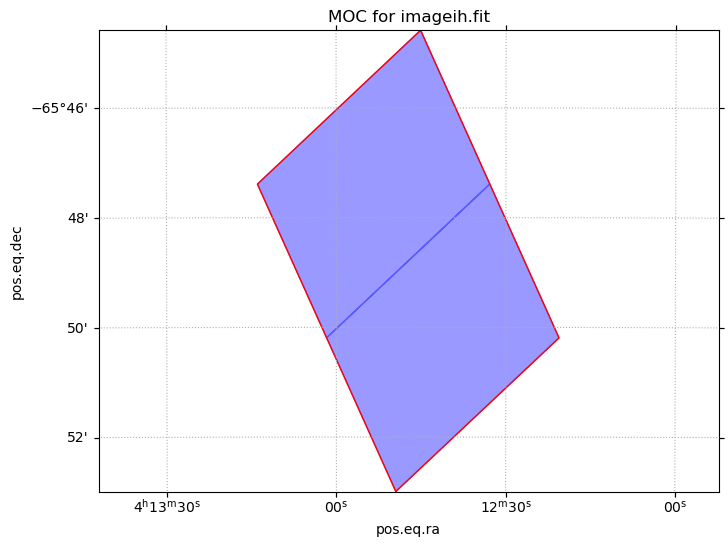

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\imagerf_moc.png


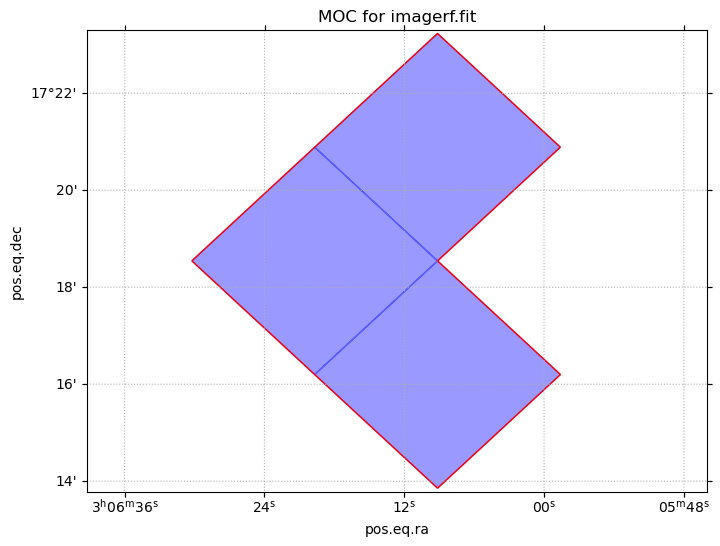

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\N2.20100426.52760_moc.png


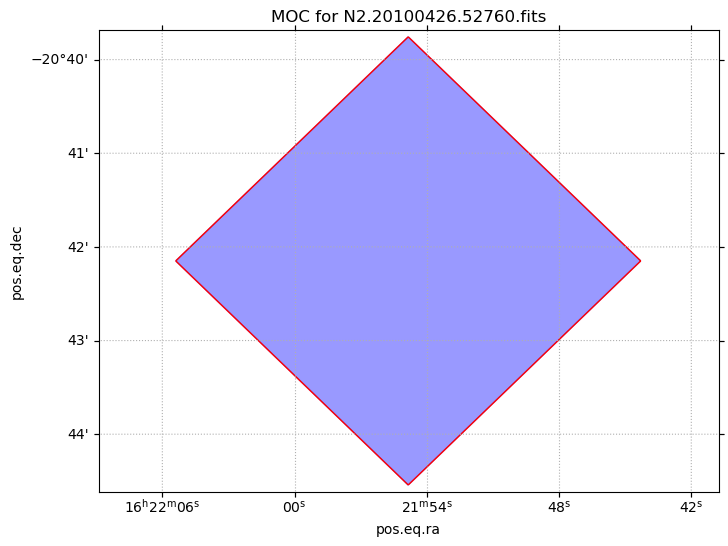

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\NGC_4486_MIPS_M1_moc.png


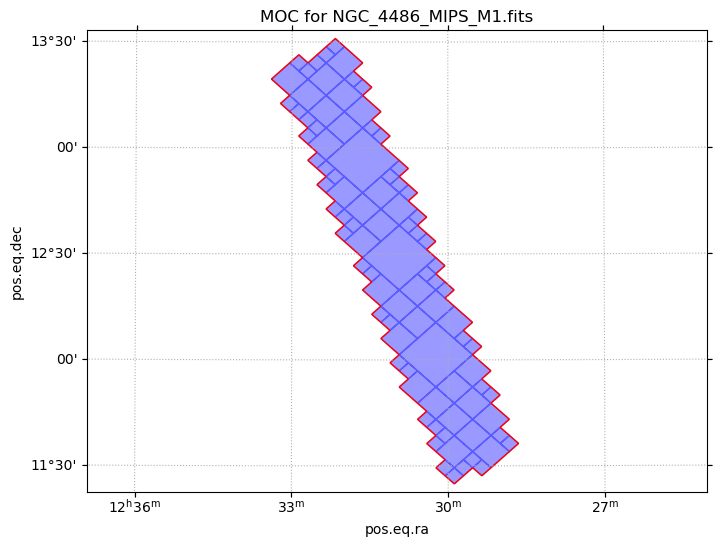

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\SN1987A_87_smHB_moc.png


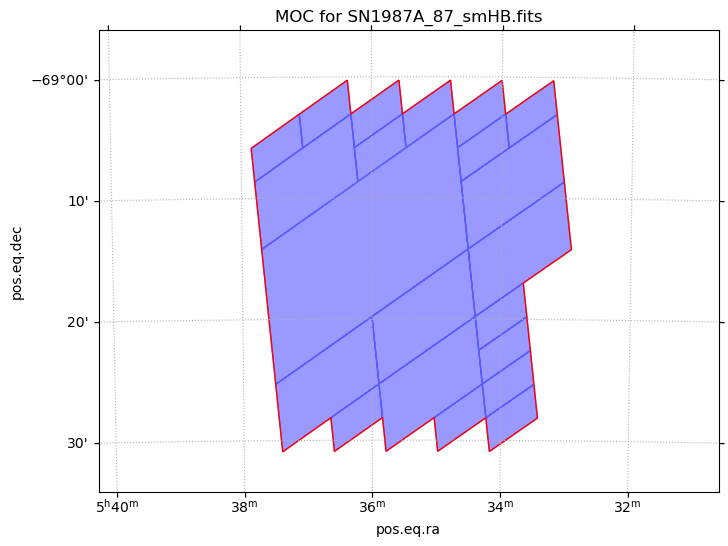

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\SN1987A_cut_35_smHB_moc.png


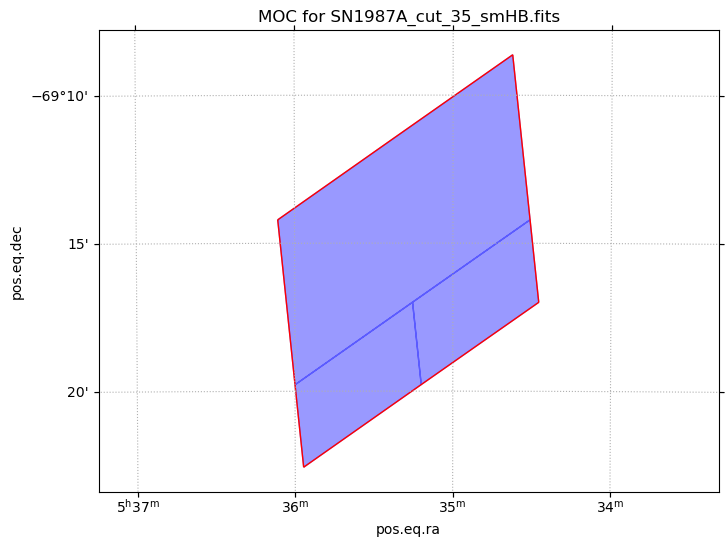

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\SNaverage5-0_moc.png


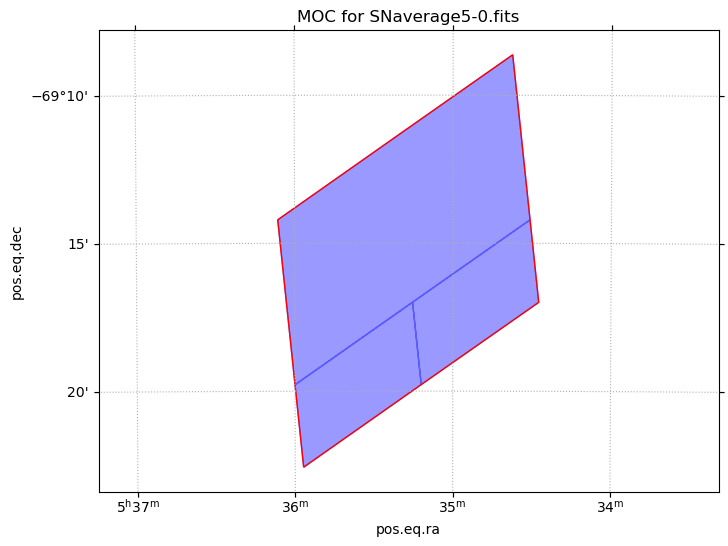

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\u_moc.png


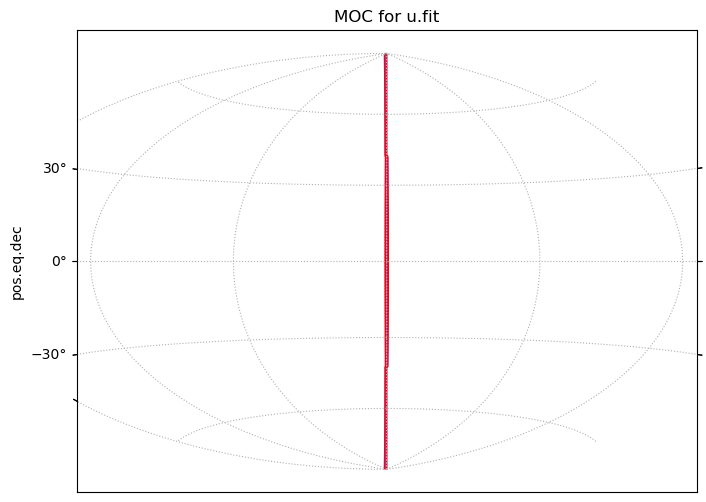

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\UGC_09618_2MASS_H_moc.png


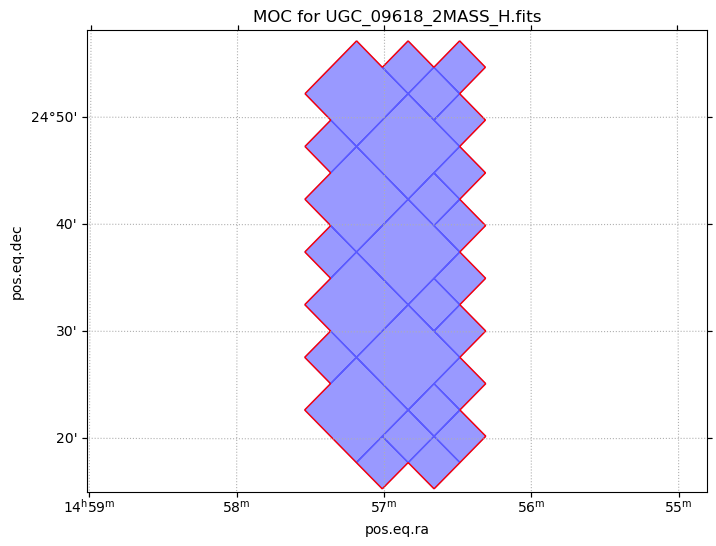

Plot saved to: C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs\UGC_09618_S_2MASS_H_moc.png


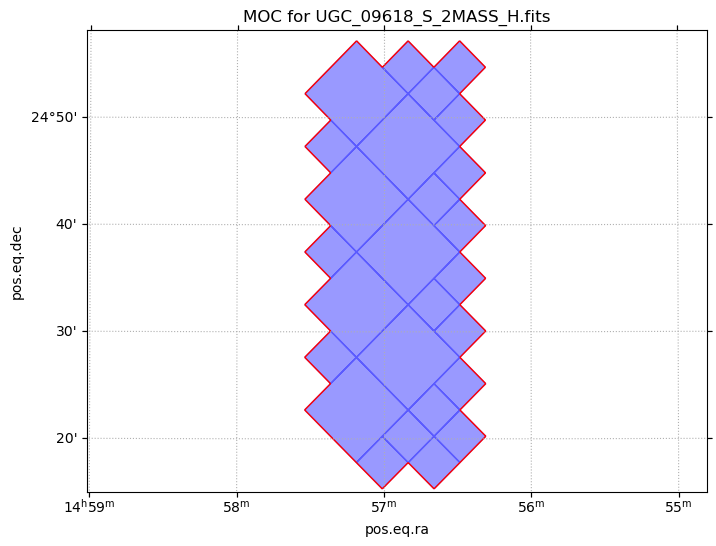

In [7]:

# Example save path
save_directory = r"C:\Academics\M2_Astro\fits_extractor_junaid\tests\saved_mocs"
os.makedirs(save_directory, exist_ok=True)

# Load MOCs + filenames from CSV
moc_data = load_mocs_and_filenames(output_file, moc_column="MOC", filename_column="FILENAME")

# Loop over each (moc_obj, fname) pair
for i, (moc_obj, fname) in enumerate(moc_data):
    if moc_obj is not None:
        save_path = os.path.join(save_directory, f"{os.path.splitext(fname)[0]}_moc.png")
        plot_moc_matplotlib(moc_obj, title=f"MOC for {fname}", save_path=save_path)
    else:
        print(f"No MOC available for row {i} (filename: {fname})")


### Plotting and Saving MOCs with Corresponding FITS Images

This code achieves the following:

1. **Functionality**:
   - The `plot_moc_and_fits` function overlays a FITS image onto its corresponding MOC coverage using the WCS from both the FITS file and the MOC object.
   - The `show_moc_fits` function handles batch processing, plotting, and saving MOCs for a specified list of FITS files.

2. **Filtering Specific Files**:
   - The code allows plotting only for a specified list of FITS files (`specific_files`) rather than processing all files in the metadata.

3. **Saving the Results**:
   - The plots are saved as PNG files in a designated directory (`save_directory`) with filenames based on the corresponding FITS file names.

4. **Process Summary**:
   - MOCs are retrieved from the metadata.
   - FITS files are loaded and plotted alongside their MOCs.
   - Each plot is displayed and saved for reference.

This section efficiently handles visualization and storage of MOCs with FITS overlays for a selected subset of files.

<span style="color:red;">**NOTE:** </span>
We do NOT use the `reproject` module due to unresolved issues in the Jupyter Notebook environment that prevented its successful import. Instead, we rely on axes transformation using `ax.get_transform(...)` to align the FITS WCS onto the MOC axes. While this approach efficiently handles alignment for most cases, misalignment may occur if the FITS WCS and MOC coverage differ significantly (e.g., in frame or reference systems).

- The MOCs are correctly generated and were earlier displayed successfully.
- Specific FITS files were chosen for overlay plotting to ensure clarity and efficient demonstration of the alignment.









In [8]:
def plot_moc_and_fits(moc_obj, fits_folder, fits_filename, title="MOC + Image", save_path=None):
    """
    Overlays a FITS image under a MOC coverage using the MOC's own WCS
    (i.e., moc_obj.wcs), without reprojecting the FITS data.

    Parameters
    ----------
    moc_obj : MOC
        A MOC object from mocpy (already parsed).
    fits_folder : str
        Folder path containing your .fits/.fit files.
    fits_filename : str
        Filename matching MOC (e.g., "av_galcen_2mass.fits").
    title : str, optional
        Title for the plot.

    Notes
    -----
    - We do NOT use reproject. Instead, we rely on transform=ax.get_transform(...)
      so the FITS WCS is mapped onto the MOC's WCS axes.
    - If the FITS WCS and MOC coverage do not align (different frames or references),
      the overlay may look misaligned.
    """
    fig = plt.figure(figsize=(8, 6))

    # 1) Build a WCS from the MOC coverage
    try:
        wcs_moc = moc_obj.wcs(fig=fig)  # MOC's bounding region
    except AttributeError:
        print("Your mocpy is too old for 'moc_obj.wcs(fig=...)'. Upgrade mocpy >= 0.10.")
        return

    ax = fig.add_subplot(111, projection=wcs_moc)
    ax.grid(True, ls=":")
    ax.set_title(title)

    # 2) Load the FITS data
    fits_path = os.path.join(fits_folder, fits_filename)
    if not os.path.isfile(fits_path):
        print(f"FITS file not found: {fits_path}. Plotting only MOC.")
    else:
        try:
            with fits.open(fits_path) as hdul:
                data = hdul[0].data
                hdr = hdul[0].header

            # If data has more than 2 dims (e.g., 3D), slice down to 2D
            while data.ndim > 2:
                data = data[0]

            # Build the WCS for the FITS
            wcs_fits = WCS(hdr)

            # Plot the data with a transform to the MOC axes
            ax.imshow(
                data,
                origin='lower',
                cmap='gray',
                alpha=0.6,
                transform=ax.get_transform(wcs_fits)  # Map fits coords -> MOC coords
            )
        except Exception as e:
            print(f"Error loading/plotting {fits_filename}: {e}")

    # 3) Overlay the MOC coverage
    moc_obj.fill(ax=ax, wcs=wcs_moc, alpha=0.4, color="blue")
    moc_obj.border(ax=ax, wcs=wcs_moc, color="red")
    
    if save_path:
        plt.savefig(save_path, format="png", dpi=300)
        print(f"Plot saved to: {save_path}")

    plt.show()


In [9]:
def show_moc_fits(moc_data, fits_folder, specific_files, save_directory):
    """
    Plots MOCs and corresponding FITS files for the given list of specific filenames.
    Saves the plots to the specified directory.

    Parameters:
        moc_data (list): List of tuples (moc_obj, fname) loaded from the CSV.
        fits_folder (str): Path to the folder containing FITS files.
        specific_files (list): List of filenames to plot.
        save_directory (str): Directory to save the plots.
    """
    # Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)

    # Filter MOC data for the specific files
    filtered_moc_data = [(moc_obj, fname) for moc_obj, fname in moc_data if fname in specific_files]
    
    # Loop through the filtered data and plot/save
    for i, (moc_obj, fname) in enumerate(filtered_moc_data):
        if moc_obj is not None:
            # Define the save path
            save_path = os.path.join(save_directory, f"{os.path.splitext(fname)[0]}_moc.png")

            # Plot and save
            plot_moc_and_fits(
                moc_obj=moc_obj,
                fits_folder=fits_folder,
                fits_filename=fname,
                title=f"MOC + Image: {fname}",
                save_path=save_path  # Pass the save path to the function
            )
            print(f"Plot for {fname} saved at {save_path}")
        else:
            print(f"No MOC for row {i} (filename={fname})")



a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


Plot saved to: fits_moc\av_galcen_2mass_moc.png


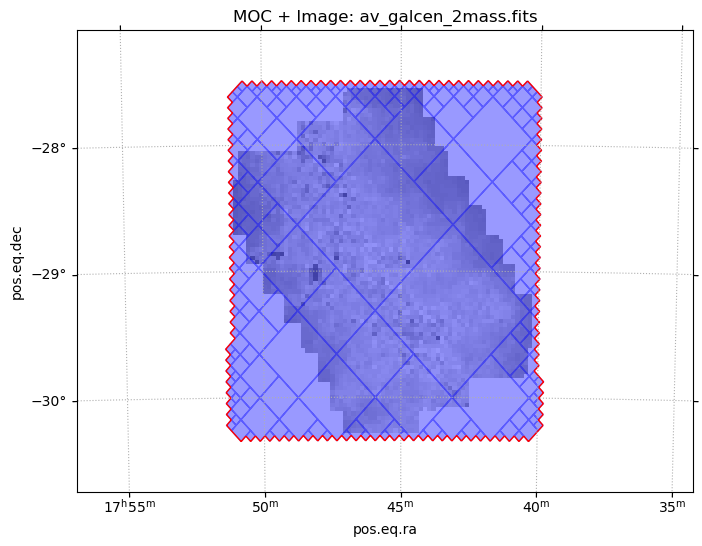

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


Plot for av_galcen_2mass.fits saved at fits_moc\av_galcen_2mass_moc.png
Plot saved to: fits_moc\av_galcen_spitzer_moc.png


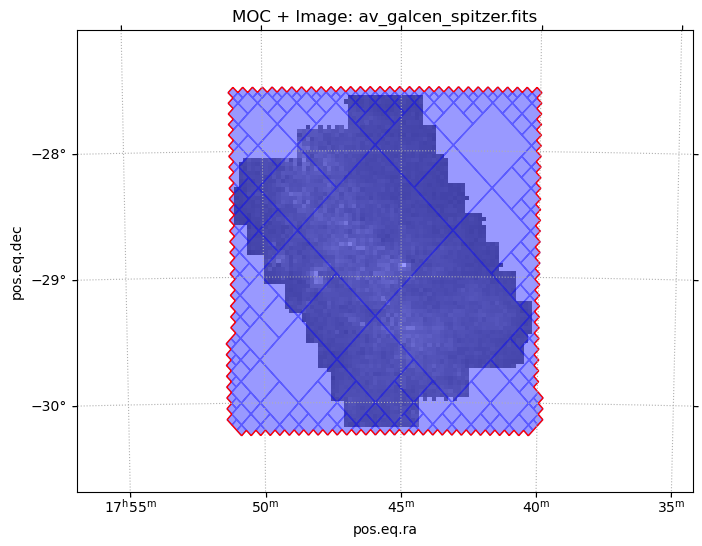

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Changed DATE-OBS from '20/09/94' to '1994-09-20''. [astropy.wcs.wcs]
Changed DATE-OBS from '20/09/94' to '1994-09-20''.


Plot for av_galcen_spitzer.fits saved at fits_moc\av_galcen_spitzer_moc.png
Plot saved to: fits_moc\imagerf_moc.png


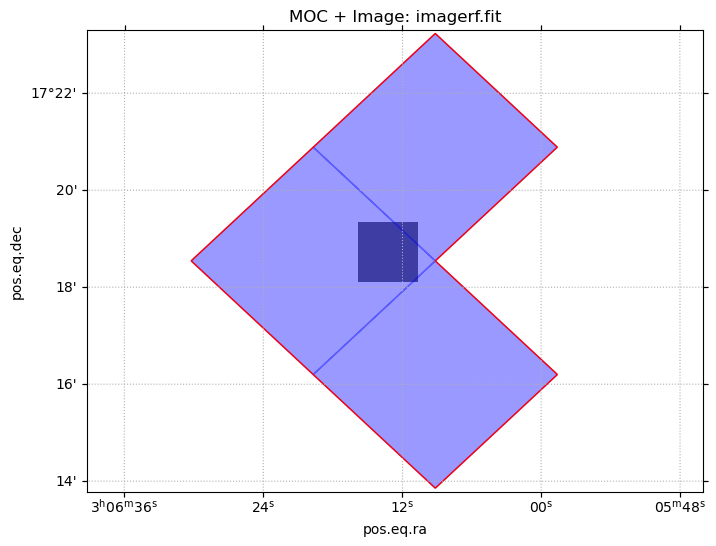

Plot for imagerf.fit saved at fits_moc\imagerf_moc.png


a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


Plot saved to: fits_moc\SN1987A_87_smHB_moc.png


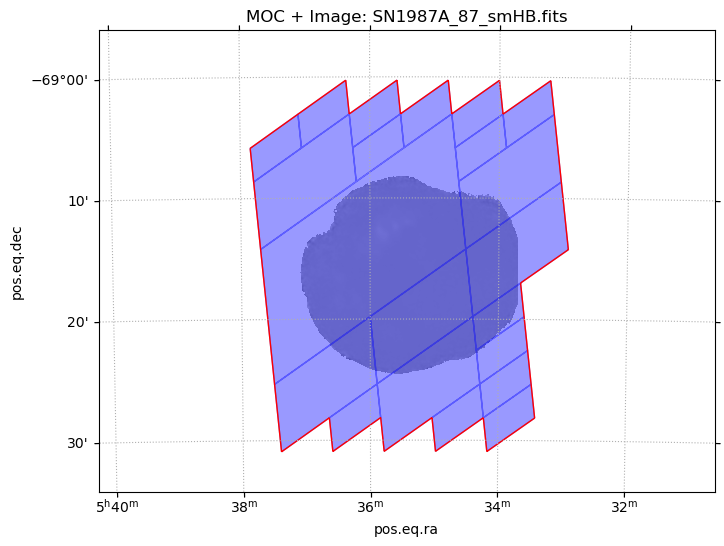

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


Plot for SN1987A_87_smHB.fits saved at fits_moc\SN1987A_87_smHB_moc.png
Plot saved to: fits_moc\SN1987A_cut_35_smHB_moc.png


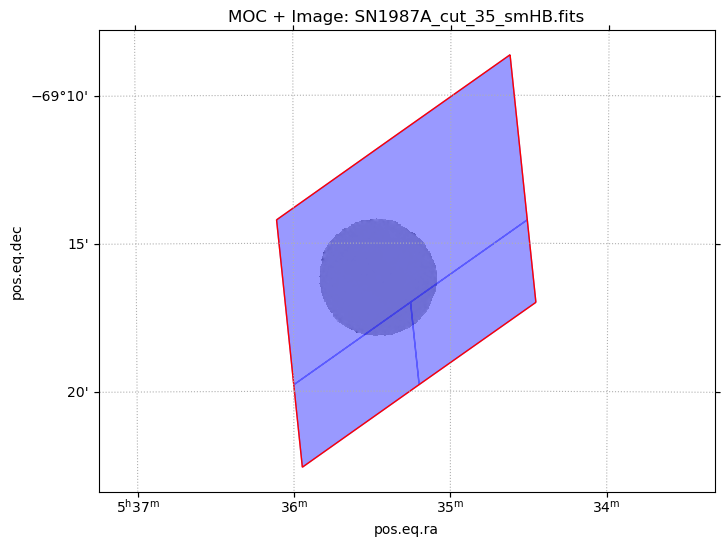

Plot for SN1987A_cut_35_smHB.fits saved at fits_moc\SN1987A_cut_35_smHB_moc.png


Plot saved to: fits_moc\SNaverage5-0_moc.png


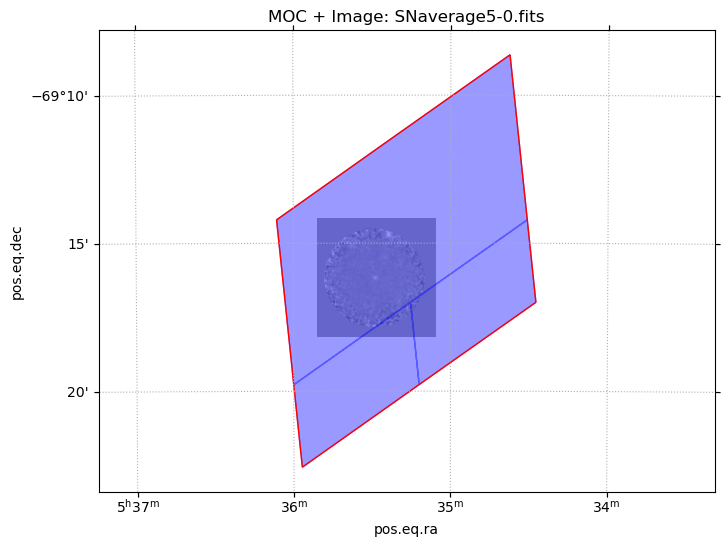

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Plot for SNaverage5-0.fits saved at fits_moc\SNaverage5-0_moc.png
Plot saved to: fits_moc\UGC_09618_2MASS_H_moc.png


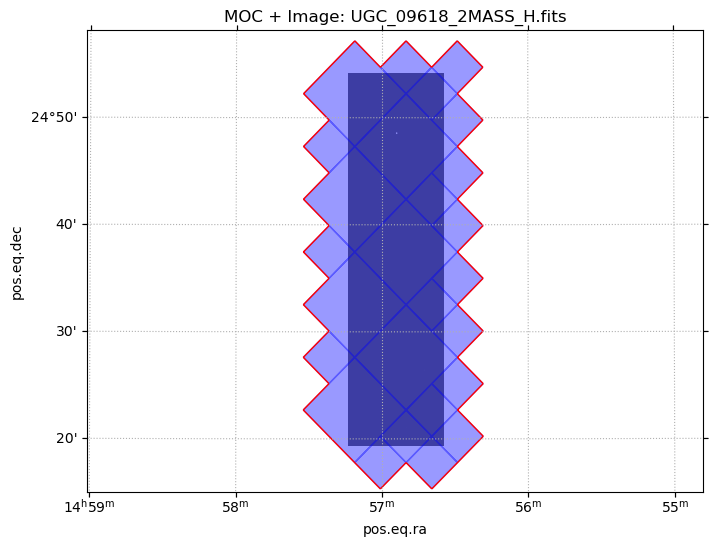

Plot for UGC_09618_2MASS_H.fits saved at fits_moc\UGC_09618_2MASS_H_moc.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Plot saved to: fits_moc\UGC_09618_S_2MASS_H_moc.png


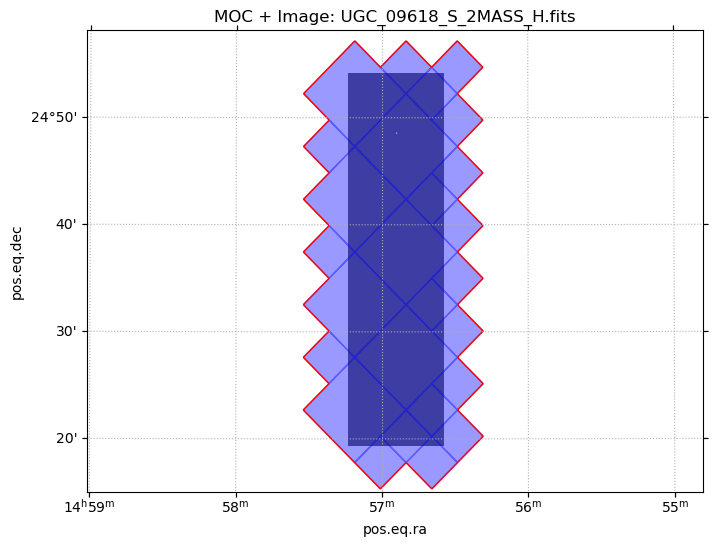

Plot for UGC_09618_S_2MASS_H.fits saved at fits_moc\UGC_09618_S_2MASS_H_moc.png


In [10]:
# Save the plots in directory
save_directory = "fits_moc"

# Specific files to plot
specific_files = [ "av_galcen_2mass.fits","av_galcen_spitzer.fits","imagerf.fit",
                 "SN1987A_87_smHB.fits", "SN1987A_cut_35_smHB.fits", "SNaverage5-0.fits",
                 "UGC_09618_2MASS_H.fits", "UGC_09618_S_2MASS_H.fits"]

show_moc_fits(moc_data, fits_folder, specific_files,save_directory)


## 2) Searching for FITS Files Containing a Specific Point

This code provides functionality to search for FITS files whose coverage includes a given point (RA, Dec). Here's an overview:

1. **Functionality**:
   - **`parse_polygon_stcs`:**
     - Parses a polygon in STCS syntax (e.g., `Polygon ICRS ra0 dec0 ra1 dec1 ...`) into a list of vertex coordinates.
   - **`search_fits_by_point`:**
     - Iterates through the metadata CSV to check if the given point is inside the polygon coverage of each FITS file.
     - Uses the `is_in_polygon` function to determine if the point lies within the polygon defined by the FITS file's coverage.

2. **Process Summary**:
   - Reads the `Polygon` column from the metadata CSV.
   - Parses the polygon's vertices using the STCS syntax.
   - Checks if the given point falls within the polygon coverage.
   - Returns a list of filenames containing the point.

3. **Example Usage**:
   - The `search_point` variable defines the point (RA, Dec) to search for.
   - The function `search_fits_by_point` is called with the metadata CSV path and the search point.
   - The results are displayed in a tabular format using a pandas DataFrame.

4. **Output**:
   - Displays the filenames of FITS files containing the point if matches are found.
   - Otherwise, prints a message indicating no matches.



In [11]:
def parse_polygon_stcs(polygon_stcs):
    """
    Parse a polygon in STCS syntax (Polygon system ra0 dec0 ra1 dec1 ...).

    Parameters:
        polygon_stcs (str): Polygon string in STCS syntax.

    Returns:
        list: List of (ra, dec) tuples representing the vertices.
    """
    if not polygon_stcs.startswith("Polygon"):
        raise ValueError("Invalid polygon syntax. Must start with 'Polygon'.")
    parts = polygon_stcs.split()
    # Skip the first two words ('Polygon' and 'system')
    coords = parts[2:]
    # Parse into tuples of (ra, dec)
    return [(float(coords[i]), float(coords[i + 1])) for i in range(0, len(coords), 2)]


def search_fits_by_point(csv_path, point):
    """
    Search for FITS files in a collection that contain a given point in their coverage polygon.

    Parameters:
        csv_path (str): Path to the CSV file containing FITS metadata.
        point (tuple): The (RA, Dec) of the point to check.

    Returns:
        list: List of filenames containing the point.
    """
    filenames = []

    with open(csv_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            polygon_stcs = row.get("Polygon", None)
            filename = row.get("FILENAME", "Unknown")

            if polygon_stcs:
                try:
                    vertices = parse_polygon_stcs(polygon_stcs)
                    if is_in_polygon(point, vertices):
                        filenames.append(filename)
                except Exception as e:
                    print(f"Error processing polygon for {filename}: {e}")

    return filenames



In [12]:
# Example usage
csv_path = r"C:\Academics\M2_Astro\fits_extractor_junaid\tests\metadata_set.csv"  # Path to your metadata CSV

#NOTE: csv_path has been already imported earlier; I just wanted to import it again for complete example
search_point = (266, -28)  # Example point in (RA, Dec)

# Find FITS files containing the given point
matching_files = search_fits_by_point(csv_path, search_point)

df = pd.DataFrame({"Filename": matching_files})

# Display the results as a table
if not df.empty:
    print("FITS files containing the point:")
    print(df)
else:
    print("No FITS files contain the point.")

FITS files containing the point:
                 Filename
0    av_galcen_2mass.fits
1  av_galcen_spitzer.fits
2                   u.fit


### 3)Searching FITS Files in Specific Regions (Circle or Polygon)



This code introduces functionality to search for FITS files whose spatial coverage intersects with a defined region (circle or polygon). It leverages the Shapely library for efficient geometric operations.

#### Overview:

1. **Functions**:
   - **`parse_polygon_stcs`**:
     - Parses polygon strings in STCS syntax (e.g., `Polygon ICRS ra0 dec0 ...`) into vertex coordinates.
   - **`create_shapely_polygon`**:
     - Converts a list of vertices into a Shapely Polygon object.
   - **`create_search_circle`**:
     - Generates a circular search region approximated by a Shapely Polygon with a specified radius and resolution.
   - **`load_metadata`**:
     - Loads the metadata CSV and parses the `Polygon` column into Shapely Polygon objects for efficient spatial queries.
   - **`find_fits_in_region`**:
     - Identifies FITS files whose spatial coverage intersects a given search region (circle or polygon).

2. **Workflow**:
   - The metadata CSV is loaded, and polygons are converted into Shapely objects for each FITS file.
   - Two example search regions are defined:
     - A **circle** centered at (RA=150°, Dec=2°) with a radius of 1°.
     - A **polygon** representing a rectangular region defined by four vertices.
   - FITS files intersecting these regions are identified and listed.

3. **Advanced Features**:
   - Allows combining multiple search regions (e.g., circle and polygon) using Shapely's geometric operations (e.g., `union`).

4. **Output**:
   - Lists FITS files that intersect with:
     - The circular region.
     - The polygonal region.
     - A combined region formed by union of the circle and polygon.


In [13]:
from shapely.geometry import Polygon, Point
import shapely.speedups

# Enable Shapely speedups if available for performance
if shapely.speedups.available:
    shapely.speedups.enable()
# Earlier function (as in point search) (just given here for the complete independent description
# of this part of the code)
def parse_polygon_stcs(polygon_stcs):
    """
    Parse a polygon in STCS syntax (Polygon system ra0 dec0 ra1 dec1 ...).

    Parameters:
        polygon_stcs (str): Polygon string in STCS syntax.

    Returns:
        list: List of (ra, dec) tuples representing the vertices.
    """
    if not polygon_stcs.startswith("Polygon"):
        raise ValueError("Invalid polygon syntax. Must start with 'Polygon'.")
    parts = polygon_stcs.split()
    # Skip the first two words ('Polygon' and 'system')
    coords = parts[2:]
    # Parse into tuples of (ra, dec)
    return [(float(coords[i]), float(coords[i + 1])) for i in range(0, len(coords), 2)]

def create_shapely_polygon(vertices):
    """
    Create a Shapely Polygon from a list of (ra, dec) tuples.

    Parameters:
        vertices (list of tuples): List of (ra, dec) tuples.

    Returns:
        shapely.geometry.Polygon: Shapely Polygon object.
    """
    try:
        return Polygon(vertices)
    except Exception as e:
        print(f"Error creating polygon: {e}")
        return None

def create_search_circle(center_ra, center_dec, radius_deg, resolution=64):
    """
    Create a Shapely Polygon approximating a circle.

    Parameters:
        center_ra (float): Right Ascension of the circle center in degrees.
        center_dec (float): Declination of the circle center in degrees.
        radius_deg (float): Radius of the circle in degrees.
        resolution (int): Number of segments to approximate the circle.

    Returns:
        shapely.geometry.Polygon: Shapely Polygon object representing the circle.
    """
    center_point = Point(center_ra, center_dec)
    # Buffer distance is in degrees; resolution defines the smoothness
    return center_point.buffer(radius_deg, resolution=resolution)

def create_search_polygon(vertices_ra_dec):
    """
    Create a Shapely Polygon from a list of (ra, dec) tuples.

    Parameters:
        vertices_ra_dec (list of tuples): List of (ra, dec) tuples defining the polygon vertices.

    Returns:
        shapely.geometry.Polygon: Shapely Polygon object.
    """
    return create_shapely_polygon(vertices_ra_dec)

def load_metadata(csv_path):
    """
    Load the metadata CSV and parse the Polygon field into Shapely Polygon objects.

    Parameters:
        csv_path (str): Path to the metadata CSV file.

    Returns:
        pandas.DataFrame: DataFrame with an additional 'Shapely_Polygon' column.
    """
    df = pd.read_csv(csv_path)
    
    def parse_and_create_polygon(polygon_str):
        try:
            vertices = parse_polygon_stcs(polygon_str)
            polygon = create_shapely_polygon(vertices)
            return polygon
        except Exception as e:
            print(f"Error processing polygon: {e}")
            return None
    
    df['Shapely_Polygon'] = df['Polygon'].apply(lambda x: parse_and_create_polygon(x) if pd.notnull(x) else None)
    return df

def find_fits_in_region(df, search_region):
    """
    Find FITS files whose polygons intersect with the search region.

    Parameters:
        df (pandas.DataFrame): DataFrame containing FITS metadata with 'Shapely_Polygon' column.
        search_region (shapely.geometry.Polygon or shapely.geometry.MultiPolygon): The search region.

    Returns:
        list: List of filenames that intersect with the search region.
    """
    matching_filenames = []
    
    for index, row in df.iterrows():
        fit_polygon = row['Shapely_Polygon']
        filename = row['FILENAME']
        
        if fit_polygon is None:
            continue  # Skip if polygon parsing failed
        
        if fit_polygon.intersects(search_region):
            matching_filenames.append(filename)
    
    return matching_filenames

def main():
    # Load metadata
    df = load_metadata(csv_path)
    if df.empty:
        print("Metadata CSV is empty or failed to load.")
        return
    
    # Define search regions
    # Example Circle: RA=, DEC=, Radius=
    search_circle = create_search_circle(center_ra=150.0, center_dec=2.0, radius_deg=1.0, resolution=64)
    
    # Example Polygon: different vertices cordinates in RA and DEC
    polygon_vertices = [
        (151.0, 2.0),
        (155.0, 2.0),
        (155.0, 3.0),
        (151.0, 3.0)
    ]   
    # its a rectange
    search_polygon = create_search_polygon(polygon_vertices)
    
    # Perform searches
    fits_in_circle = find_fits_in_region(df, search_circle)
    fits_in_polygon = find_fits_in_region(df, search_polygon)
    
    # Output results
    print("FITS files intersecting with the circle region:")
    for filename in fits_in_circle:
        print(filename)
    
    print("\nFITS files intersecting with the polygon region:")
    for filename in fits_in_polygon:
        print(filename)
    
    # Combining multiple search regions using Shapely's union
    combined_search_region = search_circle.union(search_polygon)
    fits_in_combined = find_fits_in_region(df, combined_search_region)
    
    print("\nFITS files intersecting with the combined circle and polygon regions:")
    for filename in fits_in_combined:
        print(filename)

if __name__ == "__main__":
    main()


FITS files intersecting with the circle region:
2013.1.00034.S_SB_X5_GB_X6_MB_X7_midz_cell10_25342_sci.spw0_1_2_3.cont.I.image.fits
2013.1.01292.S_SB_X4eb_GB_X4ec_MB_X4ed_2-38011_sci.spw0_1_2_3.cont.I.image.fits
id12_GAL-Survey-GC.fpsf.fits

FITS files intersecting with the polygon region:
id12_GAL-Survey-GC.fpsf.fits

FITS files intersecting with the combined circle and polygon regions:
2013.1.00034.S_SB_X5_GB_X6_MB_X7_midz_cell10_25342_sci.spw0_1_2_3.cont.I.image.fits
2013.1.01292.S_SB_X4eb_GB_X4ec_MB_X4ed_2-38011_sci.spw0_1_2_3.cont.I.image.fits
id12_GAL-Survey-GC.fpsf.fits


#### Appendix: Shows the fits files

In [15]:
from astropy.visualization import ZScaleInterval

def plot_fits_images(folder_path):
    """
    Loop over all .fits files in 'folder_path', open each one, and display
    the 2D image in a Matplotlib window with celestial coordinates (if available).

    Parameters
    ----------
    folder_path : str
        Path to the folder containing FITS files.

    Notes
    -----
    - If a FITS file has more than 2 dimensions (e.g., 3D with frequency),
      we take a single 2D slice [0, :, :] to plot.
    - Uses ZScaleInterval for auto brightness/contrast.
    - If WCS is invalid, we fall back to a simple imshow without WCS axes.
    """

    # List all .fits or .fit files in the folder
    fits_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".fit", ".fits"))
    ]

    if not fits_files:
        print(f"No .fit/.fits files found in {folder_path}.")
        return

    for f in fits_files:
        fits_path = os.path.join(folder_path, f)
        try:
            with fits.open(fits_path) as hdul:
                data = hdul[0].data
                header = hdul[0].header

                # If data has more than 2 dims (e.g., 3D or 4D), take a slice
                while data.ndim > 2:
                    data = data[0]

                # Attempt to build WCS for the header
                try:
                    wcs = WCS(header)
                    # Check if we actually have 2D WCS:
                    if wcs.naxis == 2:
                        # Use a WCS Axes
                        fig = plt.figure(figsize=(6, 5))
                        ax = fig.add_subplot(111, projection=wcs)

                        # Auto-scale brightness/contrast
                        interval = ZScaleInterval()
                        vmin, vmax = interval.get_limits(data)

                        im = ax.imshow(
                            data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray'
                        )
                        ax.set_xlabel('RA')
                        ax.set_ylabel('Dec')
                        ax.set_title(f)
                    else:
                        # Fallback: no valid 2D WCS, normal imshow
                        fig, ax = plt.subplots(figsize=(6, 5))
                        interval = ZScaleInterval()
                        vmin, vmax = interval.get_limits(data)
                        im = ax.imshow(
                            data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray'
                        )
                        ax.set_title(f)

                except Exception:
                    # If WCS fails, do a simple imshow
                    fig, ax = plt.subplots(figsize=(6, 5))
                    interval = ZScaleInterval()
                    vmin, vmax = interval.get_limits(data)
                    im = ax.imshow(
                        data, origin='lower', vmin=vmin, vmax=vmax, cmap='gray'
                    )
                    ax.set_title(f)

                plt.show()

        except Exception as exc:
            print(f"Error reading {f}: {exc}")


indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not

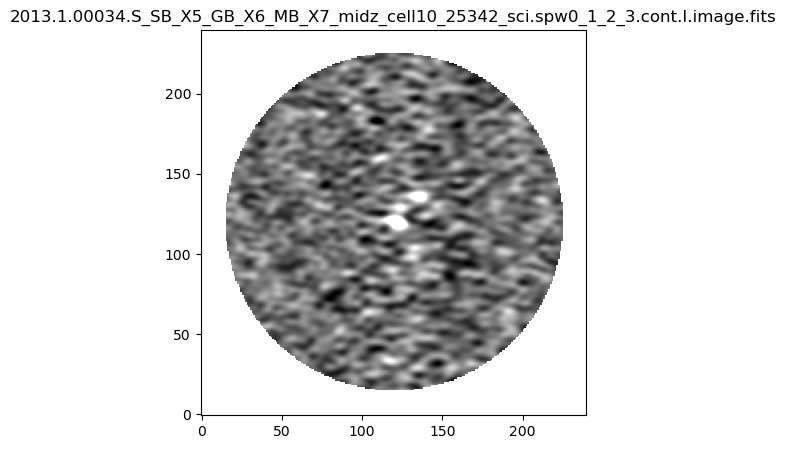

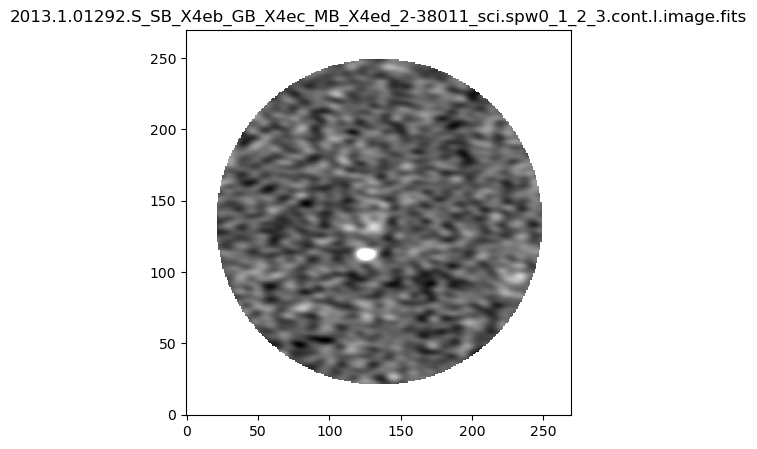

Set OBSGEO-B to   -30.312884 from OBSGEO-[XYZ].
Set OBSGEO-H to      233.860 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -30.312884 from OBSGEO-[XYZ].
Set OBSGEO-H to      233.860 from OBSGEO-[XYZ]'.


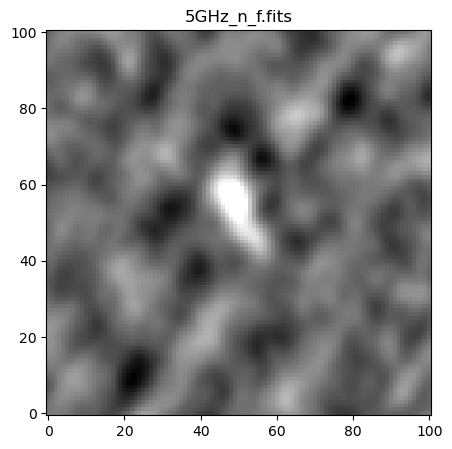

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


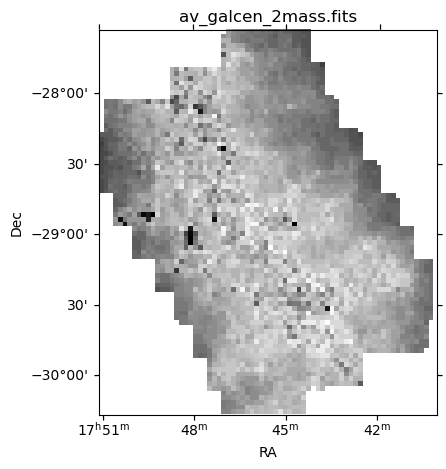

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


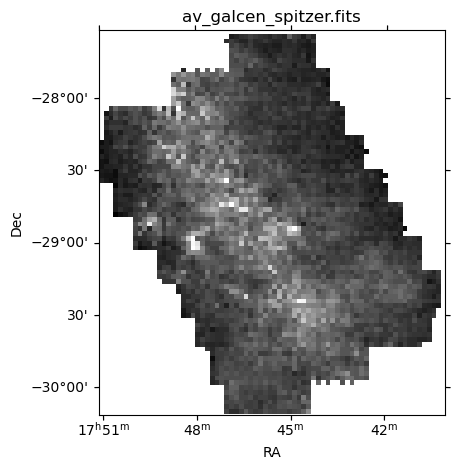

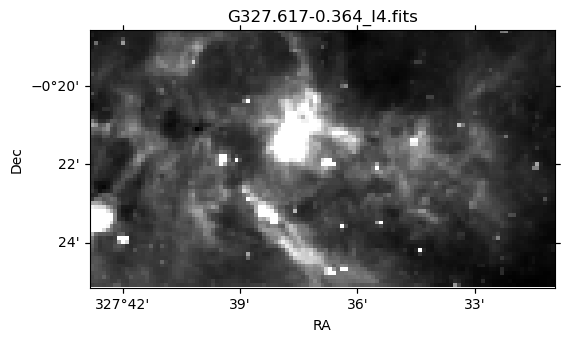

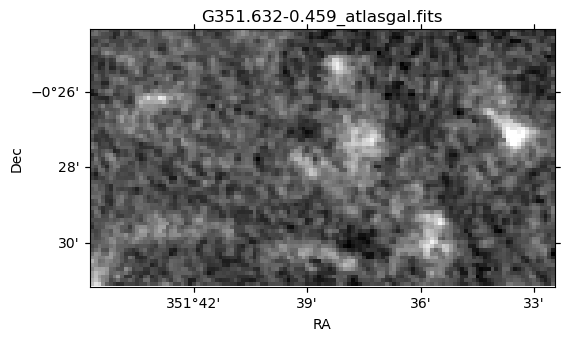

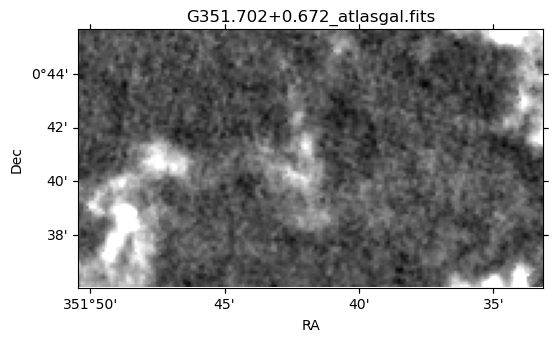

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes.
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not

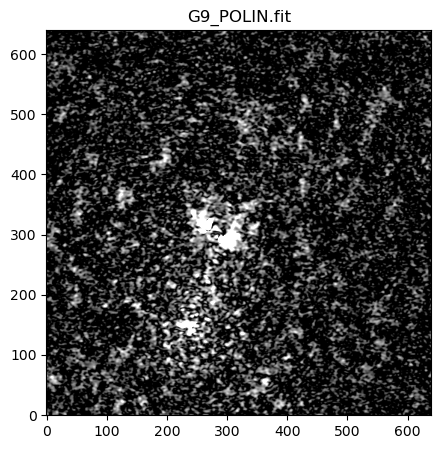

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


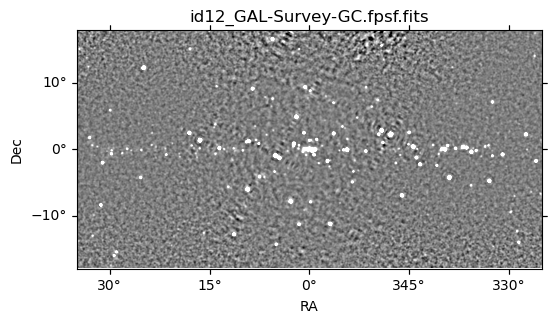

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Changed DATE-OBS from '16/11/94' to '1994-11-16''. [astropy.wcs.wcs]
Changed DATE-OBS from '16/11/94' to '1994-11-16''.


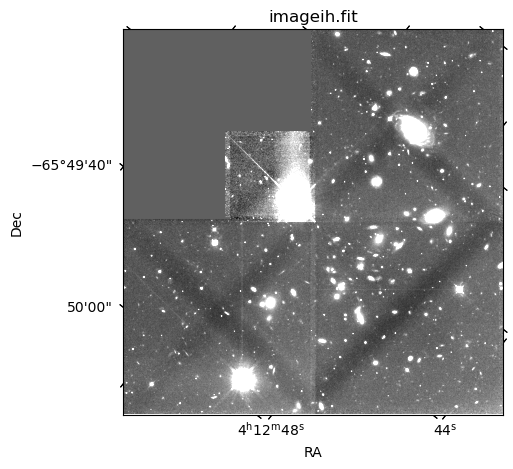

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.
Changed DATE-OBS from '20/09/94' to '1994-09-20''. [astropy.wcs.wcs]
Changed DATE-OBS from '20/09/94' to '1994-09-20''.


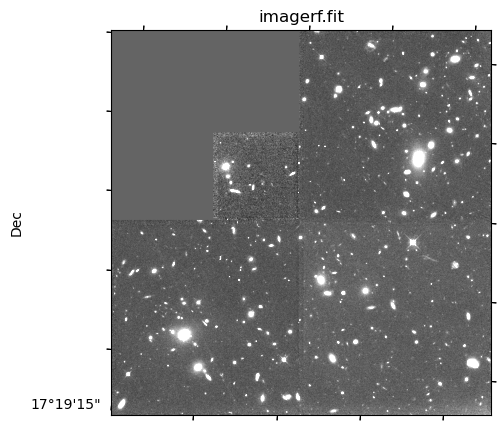

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


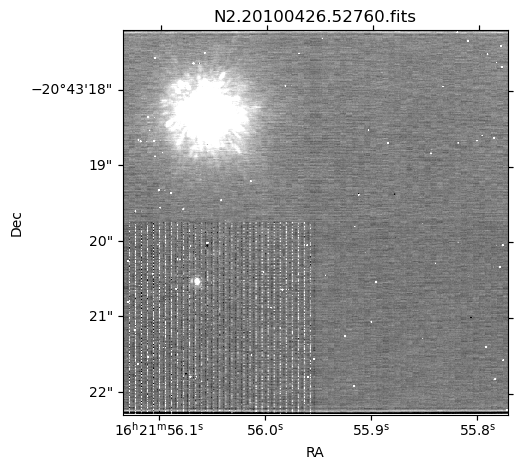

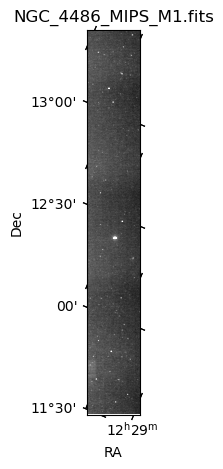

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


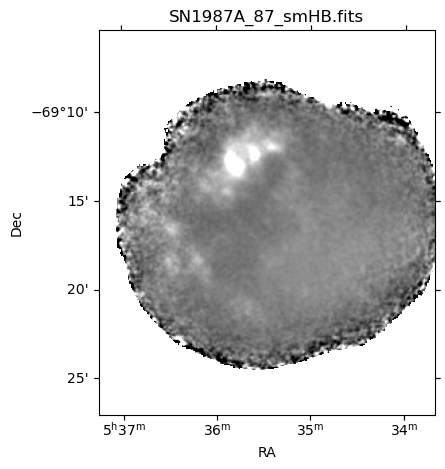

a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected.


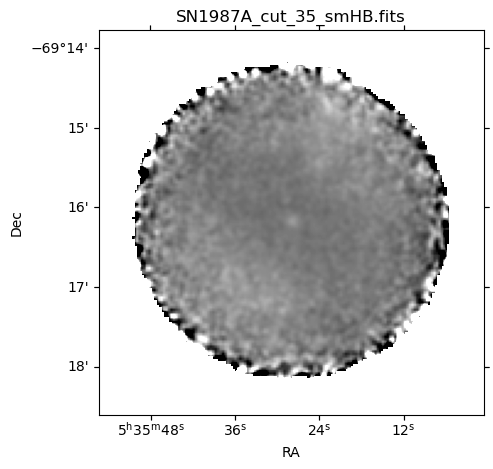

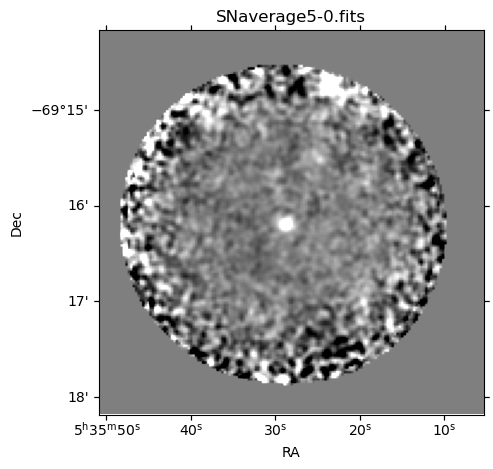

  'DEG' -> 'deg',
  'DEG' -> 'deg'. [astropy.wcs.wcs]
  'DEG' -> 'deg',
  'DEG' -> 'deg'.


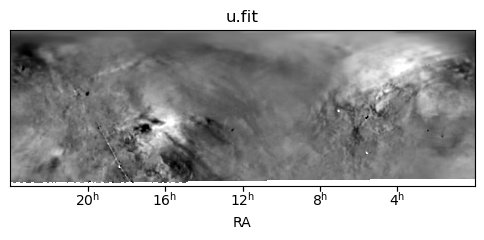

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


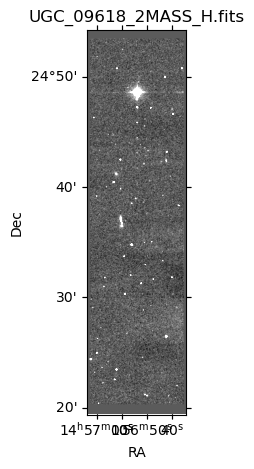

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


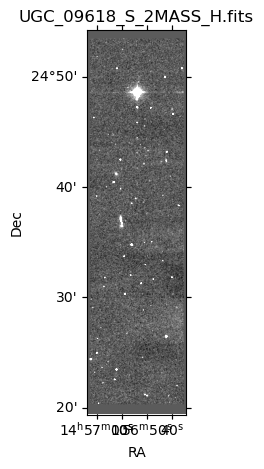

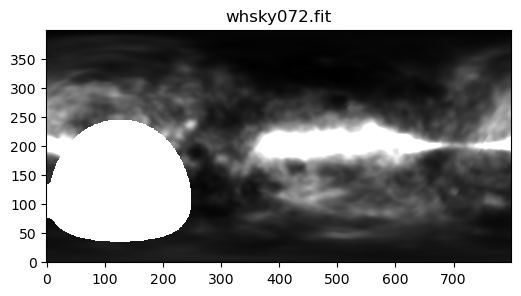

In [16]:
plot_fits_images(fits_folder)